In this notebook, we show the convergence of solution of the iterative algorithm.

In [ ]:
"""We define the class for simulating the ORGaNICs model."""
import torch
import matplotlib.pyplot as plt
import models.ORGaNICs_models as organics
from matplotlib import colors
import numpy as np
from scipy.optimize import fsolve


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
cmap = 'viridis'

In [2]:
"""Define the parameters of the model"""
N = 10
params = {
    'N_y': N,
    'N_a': N,
    'eta': 0.001,
    'noise_type': 'additive'
}
b0 = 0.5 * torch.ones(N)
b1 = 0.5 * torch.ones(N)
sigma = 0.1 * torch.ones(N)
tauA = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
tauY = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
Wyy = torch.randn(N, N)
# constrain the singular values of Wyy to be a amaximum of 1
Wyy = 1 * Wyy / torch.max(torch.abs(torch.linalg.svd(Wyy)[1]))
lambda_max = 1
# print the singular values of Wyy
print(torch.svd(Wyy)[1])
Way = torch.rand(N, N)

# Define the input drive
z = torch.relu(torch.randn(N))

tensor([1.0000, 0.7984, 0.6837, 0.5786, 0.4901, 0.3375, 0.2312, 0.2113, 0.1113,
        0.0395])


In [3]:
"""Define the model"""
model = organics.ORGaNICs2Dgeneral(params=params, b0=b0, b1=b1, sigma=sigma, tauA=tauA, tauY=tauY, Wyy=Wyy, Way=Way, z=z, run_jacobian=True)

In [4]:
num_time_to_check = 100
num_iters = 10
y_error = torch.zeros(num_time_to_check, num_iters)
a_error = torch.zeros(num_time_to_check, num_iters)

for i in range(num_time_to_check):
    print(i)
    """Define the parameters of the model"""
    N = 10
    params = {
        'N_y': N,
        'N_a': N,
        'eta': 0.001,
        'noise_type': 'additive'
    }
    b0 = torch.rand(N)
    b1 = torch.rand(N)
    sigma = torch.rand(N)
    tauA = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
    tauY = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
    Wyy = torch.randn(N, N)
    Wyy = 1 * Wyy / torch.max(torch.abs(torch.linalg.svd(Wyy)[1]))
    lambda_max = 1
    Way = torch.rand(N, N)
    # Define the input drive
    z = torch.randn(N)
    z =  z / torch.norm(z)
    model = organics.ORGaNICs2Dgeneral(params=params, b0=b0, b1=b1, sigma=sigma, tauA=tauA, tauY=tauY, Wyy=Wyy, Way=Way, z=z, run_jacobian=True)
    y = model.ss[0:N]
    a = model.ss[N:2 * N]
    z = model.z
    
    a_minus_one = (b0 * sigma) ** 2
    y_minus_one = (Wyy @ (b1 * z)) / (lambda_max - lambda_max ** 2 + lambda_max ** 2 * torch.sqrt(a_minus_one))
    a0 = (b0 * sigma) ** 2 +  Way @ ( (a_minus_one / (lambda_max - lambda_max**2 + lambda_max**2 * torch.sqrt(a_minus_one))**2) * (Wyy @ (b0 * z))**2)
    # a0 = a_minus_one
    y0 = (Wyy @ (b1 * z)) / (lambda_max - lambda_max ** 2 + lambda_max ** 2 * torch.sqrt(a0))

    y_s = y0
    a_s = a0

    y_iter = [y0]
    a_iter = [a0]

    for _ in range(num_iters):
        y_s = torch.linalg.solve((torch.eye(N) - torch.diag(1 - torch.sqrt(a_s)) @ Wyy), (b1 * z))
        a_s = ((b0 * sigma)**2 + Way @ (a_s * y_s**2))
        y_iter.append(y_s)
        a_iter.append(a_s)
        
    # find the errors for each iteration
    for j in range(num_iters):
        y_error[i, j] = torch.norm(y_iter[j] - y)
        a_error[i, j] = torch.norm(a_iter[j] - a)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


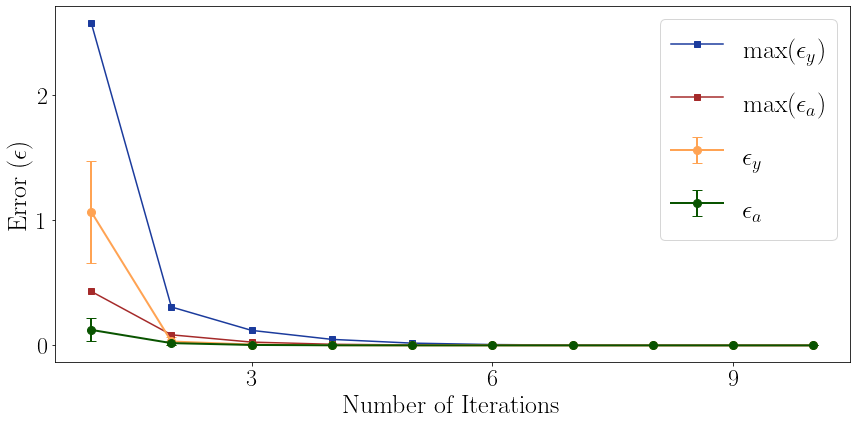

In [ ]:
y_mean = torch.mean(y_error, dim=0)
a_mean = torch.mean(a_error, dim=0)
y_std = torch.std(y_error, dim=0)
a_std = torch.std(a_error, dim=0)
y_max = torch.max(y_error, dim=0).values
a_max = torch.max(a_error, dim=0).values

y_lower = torch.clamp(y_mean - y_std, min=0)
y_upper = y_mean + y_std
a_lower = torch.clamp(a_mean - a_std, min=0)
a_upper = a_mean + a_std

# Asymmetric error values
y_err = [y_mean - y_lower, y_upper - y_mean]
a_err = [a_mean - a_lower, a_upper - a_mean]

x_iters = list(range(1, num_iters+1))

plt.figure(figsize=(12, 6))
plt.errorbar(x_iters, y_mean, yerr=y_err, fmt='-o', label='$\epsilon_y$',
             color='#FFA353', linewidth=2, markersize=8, capsize=5)
plt.errorbar(x_iters, a_mean, yerr=a_err, fmt='-o', label='$\epsilon_a$',
             color='#095400', linewidth=2, markersize=8, capsize=5)

# Plotting maximum errors
plt.plot(x_iters, y_max, '-s', label='$\max(\epsilon_y)$', color='#1B3B9D', markersize=6)
plt.plot(x_iters, a_max, '-s', label='$\max(\epsilon_a)$', color='brown', markersize=6)

plt.xticks(x_iters, fontsize=24)  # Increase tick font size and ensure ticks are integers
plt.yticks(fontsize=24)  # Increase y-tick font size

# Set face color to default white, if desired to change, uncomment and modify the line below
# plt.gca().set_facecolor('#f8f8f8')

plt.xlabel('Number of Iterations', fontsize=26)  # Increase label font size
plt.ylabel('Error ($\epsilon$)', fontsize=26)  # Increase label font size

# Removed the title by commenting out
# plt.title('Mean Errors with Standard Deviations per Iteration', fontsize=14)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(4, integer=True))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(3, integer=True))

# Enhanced legend configuration
plt.legend(fontsize=26, handlelength=2, handleheight=2, labelspacing=0.5)

plt.tight_layout()

file_name = 'convergence_averaged.svg'
file_path = '../../figures/' + file_name
plt.savefig(file_path, bbox_inches='tight', format='svg', dpi=500)
plt.show()

In [97]:
y = model.ss[0:N]
a = model.ss[N:2 * N]

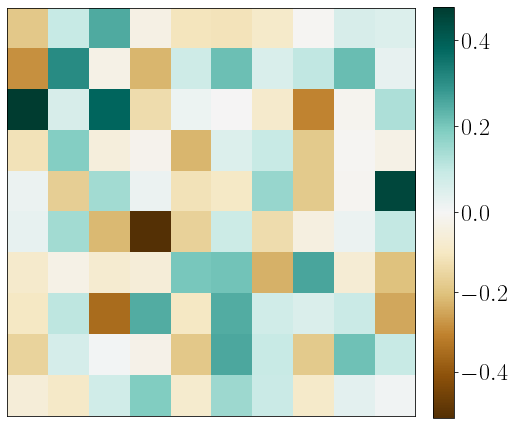

In [ ]:
divnorm = colors.TwoSlopeNorm(vmin=torch.min(Wyy), vcenter=0., vmax=torch.max(Wyy))

# Create the plot with enhanced features
plt.figure(figsize=(8, 8))  # Increased figure size for better visibility
plt.imshow(Wyy, cmap='BrBG', norm=divnorm, aspect='equal')  # Set aspect ratio to 'equal' to avoid distortion
cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Adjust colorbar size and padding
cbar.ax.tick_params(labelsize=24)
# remove ticks
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
# plt.grid(True, which='both', color='gray', linestyle='-', linewidth=0.5)  # Optional: add grid

file_name = 'Wyy.svg'
file_path = '../../figures/' + file_name
# save the figure
plt.savefig(file_path, bbox_inches='tight', format='svg', dpi=500)
plt.show()

Implementing the iterative scheme

In [125]:
z = model.z
num_iters = 10

a_minus_one = (b0 * sigma) ** 2
y_minus_one = (Wyy @ (b1 * z)) / (lambda_max - lambda_max ** 2 + lambda_max ** 2 * torch.sqrt(a_minus_one))
a0 = (b0 * sigma) ** 2 +  Way @ ( (a_minus_one / (lambda_max - lambda_max**2 + lambda_max**2 * torch.sqrt(a_minus_one))**2) * (Wyy @ (b0 * z))**2)
# a0 = a_minus_one
y0 = (Wyy @ (b1 * z)) / (lambda_max - lambda_max ** 2 + lambda_max ** 2 * torch.sqrt(a0))

y_s = y0
a_s = a0

y_iter = [y0]
a_iter = [a0]

for i in range(num_iters):
    y_s = torch.linalg.solve((torch.eye(N) - torch.diag(1 - torch.sqrt(a_s)) @ Wyy), (b1 * z))
    a_s = ((b0 * sigma)**2 + Way @ (a_s * y_s**2))
    y_iter.append(y_s)
    a_iter.append(a_s)

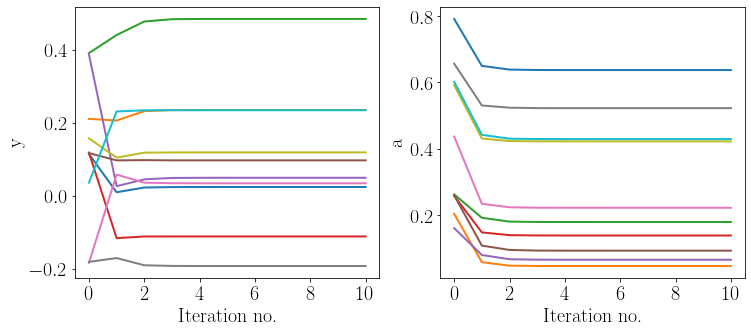

In [ ]:
# make two figures side by side with y and y_s on the left and a and a_s on the right with legend and proper figure size
fig, axes = plt.subplots(1, 2)
axes[0].plot(y_iter, label='y', linestyle='-', linewidth=2)
# add xlabel Neuron index and ylabel Membrane potential\
axes[0].set_xlabel('Iteration no.', fontsize=20)
axes[0].set_ylabel('y', fontsize=20)
# make title say y
axes[1].plot(a_iter, label='a', linestyle='-', linewidth=2)
axes[1].set_xlabel('Iteration no.', fontsize=20)
axes[1].set_ylabel('a', fontsize=20)
# increase tick tize to 20
axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)

# Ensuring x-axis only shows integer values
from matplotlib.ticker import MaxNLocator
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

fig.set_size_inches(12, 5)

file_name = 'iteration_example.svg'
file_path = '../../figures/' + file_name
plt.savefig(file_path, bbox_inches='tight', format='svg', dpi=500)
plt.show()

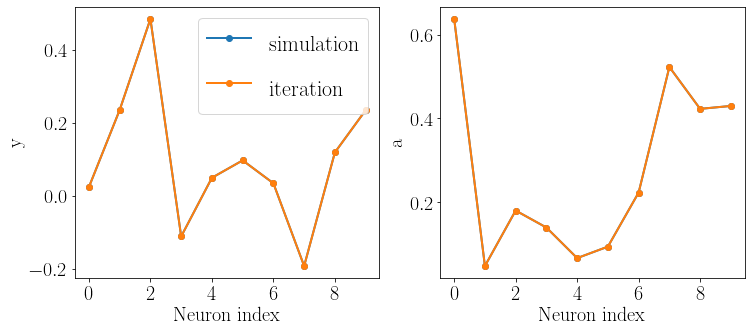

In [ ]:
# make two figures side by side with y and y_s on the left and a and a_s on the right with legend and proper figure size
fig, axes = plt.subplots(1, 2)
axes[0].plot(y, label='simulation', linestyle='-', linewidth=2, marker='o')
axes[0].plot(y_iter[-1], label='iteration', linestyle='-', linewidth=2, marker='o')
# axes[0].legend()
axes[0].set_xlabel('Neuron index', fontsize=20)
axes[0].set_ylabel('y', fontsize=20)
axes[1].plot(a, label='simulation', linestyle='-', linewidth=2, marker='o')
axes[1].plot(a_s, label='iteration', linestyle='-', linewidth=2, marker='o')
axes[1].set_ylabel('a', fontsize=20)
axes[1].set_xlabel('Neuron index', fontsize=20)
# axes[1].legend()
axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)

# Enhanced legend configuration
axes[0].legend(fontsize=22, handlelength=2, handleheight=2, labelspacing=0.5)
fig.set_size_inches(12, 5)

file_name = 'iteration_example_neurons.svg'
file_path = '../../figures/' + file_name
plt.savefig(file_path, bbox_inches='tight', format='svg', dpi=500)
plt.show()